# 1. 시계열 데이터 분석 : Random walk의 생성과 정상성 판단, ARIMA 모델




먼저, 코딩에 필요한 함수가 들어가 있는 기본 라이브러리를 불러와 줍니다.



In [1]:
import numpy as np
import pandas as pd

코드가 잘 돌아가는지 확인하기 위해, Random walk data를 생성하고, 모양을 plot으로 그려 확인해 봅시다!

<Axes: >

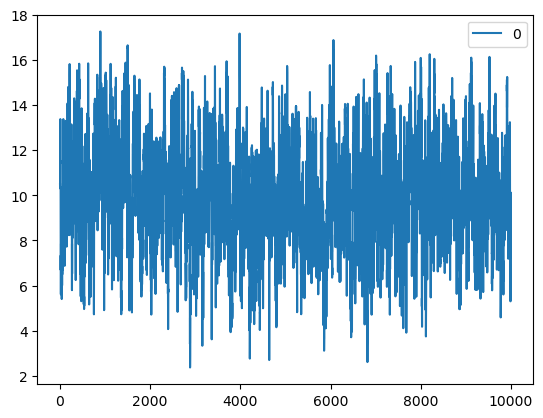

In [2]:
#무작위 보행 생성!
np.random.seed(42)
n = 10000
mean = 0
std_dev = 1
mean_reversion_speed = 0.1
data = np.zeros(n)
data[0] = np.random.randn()

for t in range(1, n):
    shock = np.random.randn() * std_dev
    data[t] = data[t-1] + mean_reversion_speed * (mean - data[t-1]) + shock
data+=10


#무작위 보행 그래프 그리기
pd.DataFrame(data).plot()

시계열 데이터를 분석하기 전, 분석이 가능한 상태인지 확인하는 정상성 검정을 시행해 봅시다.

In [3]:
from statsmodels.tsa.stattools import adfuller

정상성 검정에는 주로 adf 검정을 많이 쓰고, 이 검정은 adfuller 라이브러리를 통해 쉽게 진행할 수 있습니다.

In [4]:
def adftest(data):
    #adf 검정!
    result = adfuller(data)

    print('정상성이 있는지 판단 : ')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return key

만들어둔 data로 검정을 실시해 볼까요?

In [5]:
key = adftest(data)

정상성이 있는지 판단 : 
ADF Statistic: -23.869146
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


p-value가 0.05 이하이므로, 해당 데이터는 정상성을 갖고 있다 말할 수 있습니다.
이제 이 데이터로 시계열 데이터 분석을 진행할 수 있습니다!

In [6]:
from statsmodels.tsa.arima.model import ARIMA

기본 시계열 예측 모형인 ARIMA 모형은 statsmodel의 ARIMA 라이브러리를 사용해 쉽게 분석할 수 있습니다.

In [7]:
def ARIMA_model(data):
    #델타yt의 경우와 그냥 yt의 경우에 감마의 값에 따라 평균회귀 가능성이 어떻게 달라지는지 조심하세요
    model = ARIMA(data, order=(1, 0, 0))
    model_fit = model.fit()
    print(f'λ 값의 유도(델타yt가 아닌 그냥 yt임 주의!!) : { model_fit.params[1] }')
    half = -np.log(2)/(model_fit.params[1]-1)
    print(f'반감기 : {half}')

    display(model_fit.summary())
    return half

만들어둔 데이터로 모델에 fitting 시켜 봅시다!

In [8]:
half=ARIMA_model(data)

λ 값의 유도(델타yt가 아닌 그냥 yt임 주의!!) : 0.8921572669821072
반감기 : 6.427388857485104


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -14222.642
Date:                Sun, 31 Mar 2024   AIC                          28451.283
Time:                        11:17:04   BIC                          28472.914
Sample:                             0   HQIC                         28458.605
                              - 10000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9794      0.093    107.273      0.000       9.797      10.162
ar.L1          0.8922      0.005    195.268      0.000       0.883       0.901
sigma2         1.0065      0.014     71.183      0.000       0.979       1.034
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 0.30
Prob(Q):                              0.51   Prob(JB):                         0.86
Heteroskedasticity (H):               1.04   Skew:                             0.00
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 2. Random walk의 반감기를 측정하는 Hurst 지수 검정

정상성 검정과 ARIMA 모델을 실습했다면, 이제 Hurst 지수 검정을 진행할 차례입니다.

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression

기본 라이브러리를 불러온 뒤, RS공식과 지수를 계산하는 함수를 제작해 봅시다!

In [10]:
#허스트 지수 유도를 위한 RS 공식(변동성) 함수
def RS_func(data):
    L = np.log10(data[1:] / data[:-1])
    Z = np.mean(L)
    C = np.cumsum(L-Z)
    R = max(C) - min(C)
    S = np.std(L)

    if R == 0 or S == 0:
        return 0

    return R / S

#허스트 지수 검정 계산  <- basic exponent
def hurst_func(data):
    min_window = 10
    max_window = len(data) - 1
    by_factor = np.log10(2.0)
    window_sizes = list(map(lambda x: int(10 ** x),np.arange(np.log10(min_window), np.log10(max_window), by_factor)))
    window_sizes.append(len(data))

    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(data), w):
            if (start + w) > len(data):
                break
            res = RS_func(data[start:start + w].astype(np.float64))
            if res != 0:
                rs.append(res)
        RS.append(np.mean(rs))

    lm1 = LinearRegression().fit(np.log10(window_sizes).reshape(-1, 1),np.log10(RS).reshape(-1, 1))
    hurst_exp = lm1.coef_[0][0]
    return hurst_exp

허스트 검정 함수를 데이터로 실습해 볼까요?

In [11]:
hurst_func(data)

0.25173651809405323

# 3. 백테스트를 위한 포지션 함수 생성

백테스트를 통해 분석 결과를 확인해 봅시다.

In [12]:
# 백테스트를 위한 포지션 함수
def position(data,half):
    overall_mean = np.mean(data)
    overall_std = np.std(data)
    overall_mean, overall_std
    df = pd.DataFrame(data, columns=['price'])
    df['mean'] = overall_mean
    df['std'] = overall_std
    df['upper'] = overall_mean + 2*overall_std
    df['lower'] = overall_mean - 2*overall_std

    holding_period = half  # 가정한 보유 기간
    stop_loss_threshold = 0.2  # 손절 기준
    positions = []

    for i in range(1, len(df)):
        current_price = df.iloc[i]['price']
        previous_price = df.iloc[i-1]['price']
        upper_bound = df.iloc[i]['upper']
        lower_bound = df.iloc[i]['lower']

        if not positions or positions[-1]['exit_price'] is not None:
            if previous_price > upper_bound and current_price <= upper_bound:
                positions.append({'type': 'short', 'entry_price': current_price, 'entry_index': i, 'exit_price': None})
            elif previous_price < lower_bound and current_price >= lower_bound:
                positions.append({'type': 'long', 'entry_price': current_price,'entry_index': i,  'exit_price': None})

        if positions and positions[-1]['exit_price'] is None:
            position = positions[-1]
            elapsed_time = i - position['entry_index']
            loss = 0

            if position['type'] == 'long':
                loss = (current_price - position['entry_price']) / position['entry_price']
            else:
                loss = (position['entry_price'] - current_price) / position['entry_price']

            #손절,익절 공식 : 스탑로스컷 맞는지 확인 and 보유기간 넘는지 확인 and 평균 돌아왔는지
            if loss < -stop_loss_threshold or elapsed_time > holding_period or (position['type'] == 'long' and current_price >= overall_mean) or (position['type'] == 'short' and current_price <= overall_mean):
                position['exit_price'] = current_price
                position['pnl'] = loss
                position['elapsed_day']= elapsed_time

    positions_summary = [{'type': p['type'], 'entry_price': p['entry_price'], 'exit_price': p['exit_price'], 'pnl': p['pnl'],'entry_day':p['entry_index'],'elapsed_day':p['elapsed_day']} for p in positions if p['exit_price'] is not None]
    return positions_summary


함수의 작동 확인을 위해, 데이터를 넣고 마지막 10개의 포지션을 출력해 봅시다.

In [13]:
positions = position(data,half)
positions[:-10]

[{'type': 'long',
  'entry_price': 6.061423599876523,
  'exit_price': 6.008350988634831,
  'pnl': -0.00875579975020609,
  'entry_day': 39,
  'elapsed_day': 7},
 {'type': 'short',
  'entry_price': 13.459573954862652,
  'exit_price': 11.215357617532225,
  'pnl': 0.16673754643768943,
  'entry_day': 181,
  'elapsed_day': 7},
 {'type': 'short',
  'entry_price': 13.892150626037438,
  'exit_price': 10.68268335232909,
  'pnl': 0.23102738806279477,
  'entry_day': 216,
  'elapsed_day': 7},
 {'type': 'short',
  'entry_price': 13.393735049373982,
  'exit_price': 9.699017983089188,
  'pnl': 0.2758541252805716,
  'entry_day': 375,
  'elapsed_day': 7},
 {'type': 'short',
  'entry_price': 14.239813997532972,
  'exit_price': 12.869384770287624,
  'pnl': 0.09623926460575767,
  'entry_day': 422,
  'elapsed_day': 7},
 {'type': 'long',
  'entry_price': 7.935972375761707,
  'exit_price': 9.80811900359391,
  'pnl': 0.23590639422462864,
  'entry_day': 460,
  'elapsed_day': 7},
 {'type': 'long',
  'entry_price

#4. 백테스트 코드

백테스트를 실시하기 위해, 백테스트 함수를 짜 봅니다.

In [14]:
import matplotlib.pyplot as plt
# 포지션 가지구 백테스트
def backtest(positions):
    initial_capital = 1000000

    capital = initial_capital
    capital_history = [capital]

    for position in positions:
        if position['exit_price']:
            pnl = position['pnl']
            profit = capital * pnl
            capital += profit
            capital_history.append(capital)
    time_stamps = [i for i, _ in enumerate(capital_history)]

    # 그래프 초기화 및 그리기
    plt.figure(figsize=(14, 7))
    plt.plot(time_stamps, capital_history, label='Capital Over Time', color='blue', marker='o')

    plt.title('Portfolio Value Over Time')
    plt.xlabel('days')
    plt.ylabel('Portfolio Value')
    plt.legend()

    plt.show()

포지션을 백테스트 함수에 넣어 plot을 확인해 봅시다.

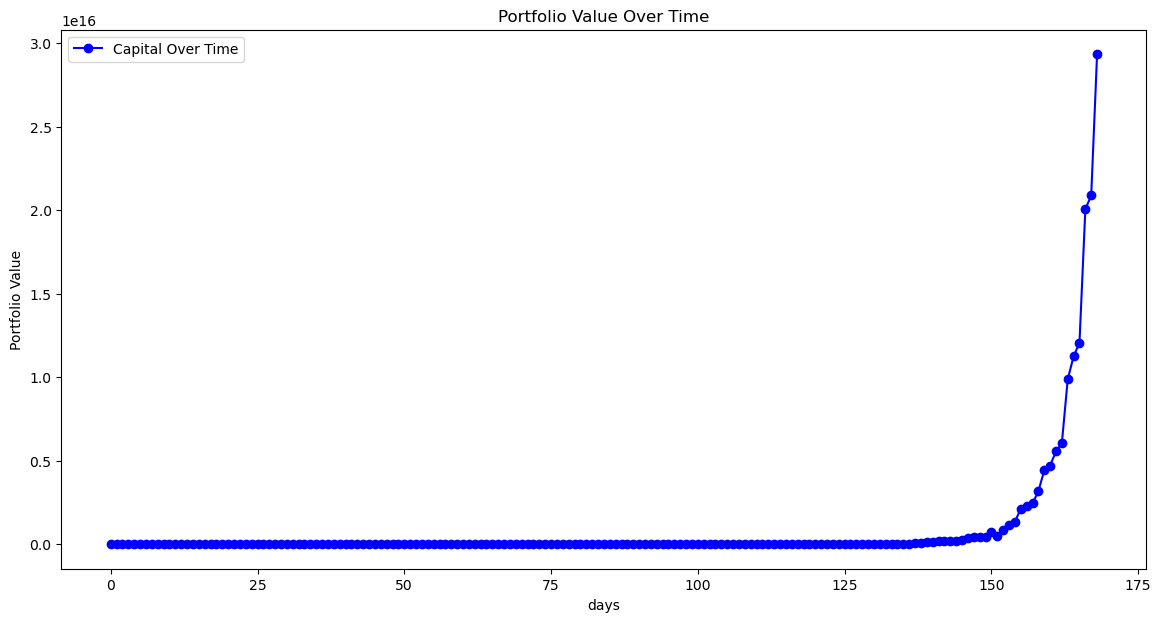

In [15]:
backtest(positions)

# 5. 코스피 데이터로 똑같이 따라해보기!

어떻게 사용하는지 헷갈릴까봐 코스피 데이터를 통해서 실행하는 예제입니다

In [16]:
data = pd.read_excel('C:/Users/82107/Desktop/동아리/algorithm trading/코스닥코스피.xlsx')['코스피']
data.name = 'price'
data

0       1918.76
1       1930.53
2       1925.43
3       1904.33
4       1917.62
         ...   
2014    2497.09
2015    2497.09
2016    2497.09
2017    2497.09
2018    2497.09
Name: price, Length: 2019, dtype: float64

1) 데이터의 형태 plot으로 확인하기

<Axes: >

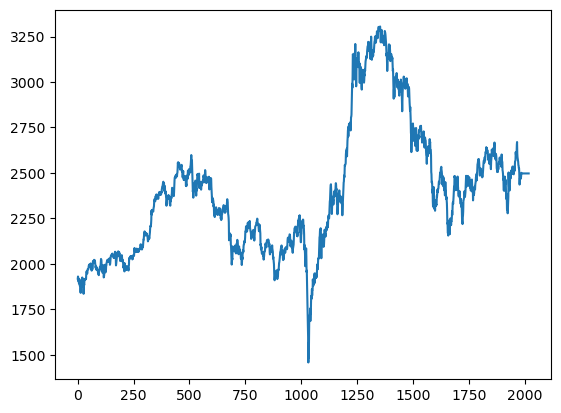

In [24]:
#빈칸을 채워 보세요!

2) 시계열 데이터가 정상성을 갖는지 검정하기

In [25]:
#빈칸을 채워 보세요!

정상성이 있는지 판단 : 
ADF Statistic: -1.885626
p-value: 0.338853
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


3) 시계열 데이터로 ARIMA 모델 fitting 하기

In [26]:
 #빈칸을 채워 보세요!

λ 값의 유도(델타yt가 아닌 그냥 yt임 주의!!) : 0.997573917447784
반감기 : 285.7063457823488


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2019
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -9300.132
Date:                Sun, 31 Mar 2024   AIC                          18606.264
Time:                        11:17:32   BIC                          18623.095
Sample:                             0   HQIC                         18612.441
                               - 2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2389.0556    168.435     14.184      0.000    2058.930    2719.182
ar.L1          0.9976      0.001    825.569      0.000       0.995       1.000
sigma2       585.2687     11.538     50.726      0.000     562.655     607.882
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               831.32
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               2.66   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

4) Hurst 지수 검정하기

In [27]:
data = data.to_numpy() #데이터 형식 맞추기
#빈칸을 채워 보세요!

0.6239491790851018

5) Position 만들고 확인하기

In [28]:
#빈칸을 채워 보세요!

[{'type': 'long',
  'entry_price': 1704.76,
  'exit_price': 2418.67,
  'pnl': 0.41877449025082714,
  'entry_day': 1036,
  'elapsed_day': 95},
 {'type': 'short',
  'entry_price': 3085.9,
  'exit_price': 2659.23,
  'pnl': 0.13826436371885029,
  'entry_day': 1236,
  'elapsed_day': 286}]

6) 백테스트

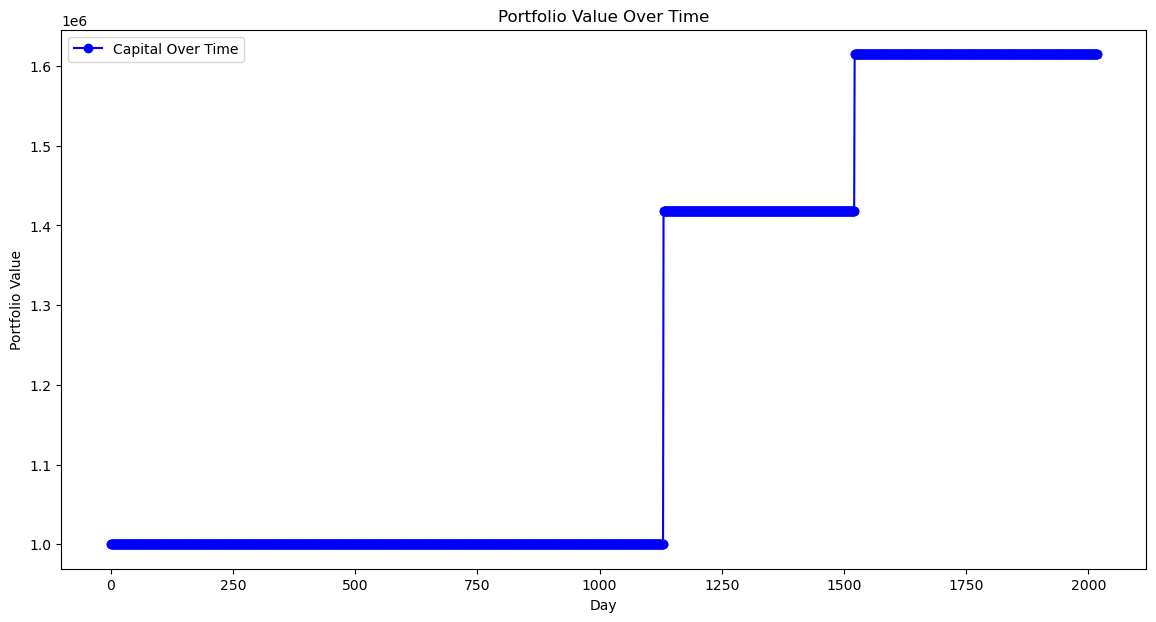

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def backtest(data, positions):
    initial_capital = 1000000
    capital = initial_capital
    capital_history = [initial_capital]
    sorted_positions = sorted(positions, key=lambda x: x['entry_day'])

    last_day = 0
    for position in sorted_positions:
        pnl = position['pnl']
        day = position['entry_day'] + position['elapsed_day']
        for _ in range(day - last_day - 1):
            capital_history.append(capital)

        capital += capital * pnl
        capital_history.append(capital)
        last_day = day

    for _ in range(len(data) - last_day - 1):
        capital_history.append(capital)
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(data)), capital_history, label='Capital Over Time', color='blue', marker='o')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Day')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()


data_length = 300
data_example = np.zeros(data_length)
backtest(data, positions)

7) position 진입 시점과 종료 시점 확인하기

[{'type': 'long',
  'entry_price': 1704.76,
  'exit_price': 2418.67,
  'pnl': 0.41877449025082714,
  'entry_day': 1036,
  'elapsed_day': 95},
 {'type': 'short',
  'entry_price': 3085.9,
  'exit_price': 2659.23,
  'pnl': 0.13826436371885029,
  'entry_day': 1236,
  'elapsed_day': 286}]

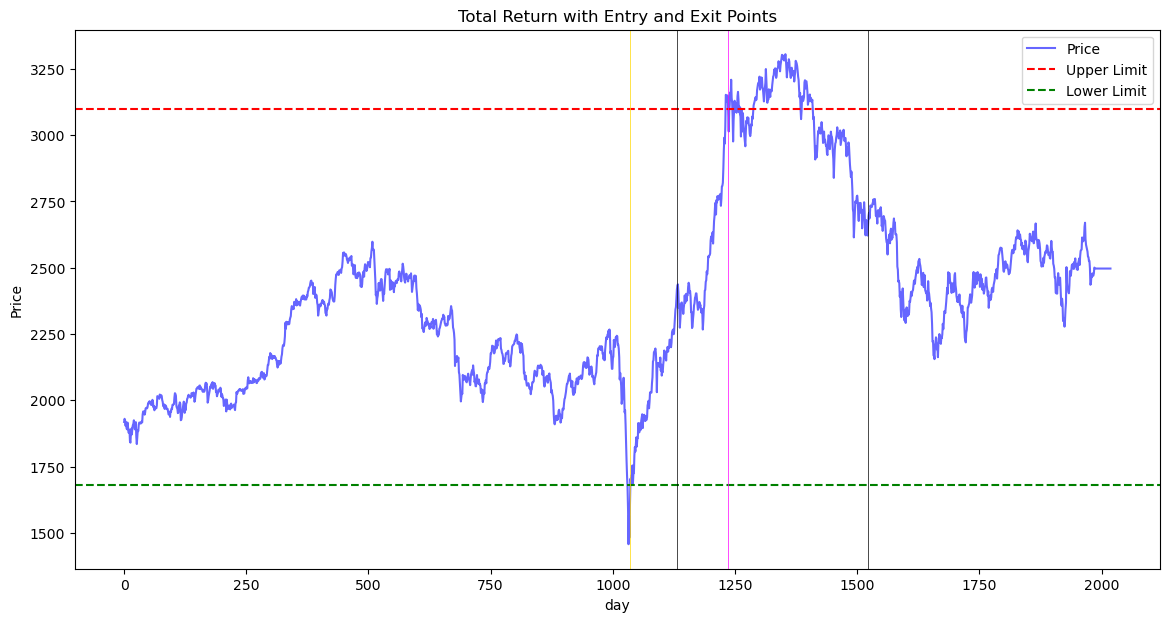

In [30]:
#포지션 진입 시점과 종료 시점 그래프
def when(data):
    overall_mean = np.mean(data)
    overall_std = np.std(data)
    overall_mean, overall_std
    df = pd.DataFrame(data, columns=['price'])
    df['mean'] = overall_mean
    df['std'] = overall_std
    df['upper'] = overall_mean + 2*overall_std
    df['lower'] = overall_mean - 2*overall_std

    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['price'], label='Price', color='blue', alpha=0.6)
    plt.axhline(y=overall_mean + 2*overall_std, color='red', linestyle='--', label='Upper Limit')
    plt.axhline(y=overall_mean - 2*overall_std, color='green', linestyle='--', label='Lower Limit')
    display(positions)

    for position in positions:
        entry_index = position['entry_day']
        if position['exit_price']:
            exit_index = position['entry_day'] + position['elapsed_day']
            if position['type'] == 'long':
                plt.axvline(x=entry_index, color='gold', linestyle='-', linewidth=0.5)
                plt.axvline(x=exit_index, color='black', linestyle='-', linewidth=0.5)
            else:
                plt.axvline(x=entry_index, color='magenta', linestyle='-', linewidth=0.5)
                plt.axvline(x=exit_index, color='black', linestyle='-', linewidth=0.5)

    plt.legend()
    plt.title('Total Return with Entry and Exit Points')
    plt.xlabel('day')
    plt.ylabel('Price')
    plt.show()

when(data)

각자 데이터를 다운받아 5번의 과정에 맞게 실습을 진행하고,
백테스트 결과를 전송해 주세요.